In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.calculate_index import format_df, calculate_index, weight_domains, print_index_summary
from scripts.utils.index_plot import index_plot, index_domain_plot

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data'
output_folder = 'aws_csvs'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data.


In [3]:
built_domain = pd.read_csv(r'aws_csvs/built_domain_index_calculation.csv')
governance_domain = pd.read_csv(r'aws_csvs/governance_domain_index_calculation.csv')
natural_domain = pd.read_csv(r'aws_csvs/natural_domain_index_calculation.csv')
society_domain = pd.read_csv(r'aws_csvs/society_economy_domain_index_calculation.csv')
climate_domain = pd.read_csv(r'aws_csvs/climate_domain_index_calculation.csv')

In [4]:
# Keep only the first two columns
built_domain_cleaned = built_domain.iloc[:, :2]
governance_domain_cleaned = governance_domain.iloc[:, :2]
natural_domain_cleaned = natural_domain.iloc[:, :2]
society_domain_cleaned = society_domain.iloc[:, :2]
climate_domain_cleaned = climate_domain.iloc[:, :2]

Next, we'll read in the synthetic climate indicator data as well, so we can calculate the Index across California. 

In [5]:
merged_domains = pd.merge(governance_domain_cleaned, built_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, natural_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, society_domain_cleaned, on='GEOID', how='left')

In [6]:
# Ensure all values in GEOID are strings
merged_domains['GEOID'] = merged_domains['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
merged_domains['GEOID'] = merged_domains['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max() + 1)

# Rename the standardized columns for simplicity
merged_domains = merged_domains.rename(columns={
    'summed_indicators_governance_domain_min_max_standardized':'governance_domain_index',
    'summed_indicators_built_domain_min_max_standardized':'built_domain_index',
    'summed_indicators_natural_domain_min_max_standardized':'natural_systems_domain_index', 
    'summed_indicators_society_economy_domain_min_max_standardized':'society_economy_domain_index'     
})

# Display the dataframe
merged_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index
0,06001400100,0.657823,0.701072,0.706555,0.704602
1,06001400200,0.657823,0.754271,0.454009,0.695877
2,06001400300,0.657823,0.750204,0.854000,0.746512
3,06001400400,0.657823,0.758585,0.837761,0.770337
4,06001400500,0.657823,0.754902,0.829855,0.796901
...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060
9125,06115041001,0.638738,0.895790,0.749494,0.740463
9126,06115041002,0.638738,0.879166,0.652535,0.715148
9127,06115041101,0.638738,0.921867,0.571603,0.747091


In [7]:
all_domains = merged_domains.copy()
all_domains['built_median'] = merged_domains['built_domain_index'].median()
all_domains['natural_systems_median'] = merged_domains['natural_systems_domain_index'].median()
all_domains['society_economy_median'] = merged_domains['society_economy_domain_index'].median()

all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median
0,06001400100,0.657823,0.701072,0.706555,0.704602,0.662419,0.714087,0.769649
1,06001400200,0.657823,0.754271,0.454009,0.695877,0.662419,0.714087,0.769649
2,06001400300,0.657823,0.750204,0.854000,0.746512,0.662419,0.714087,0.769649
3,06001400400,0.657823,0.758585,0.837761,0.770337,0.662419,0.714087,0.769649
4,06001400500,0.657823,0.754902,0.829855,0.796901,0.662419,0.714087,0.769649
...,...,...,...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060,0.662419,0.714087,0.769649
9125,06115041001,0.638738,0.895790,0.749494,0.740463,0.662419,0.714087,0.769649
9126,06115041002,0.638738,0.879166,0.652535,0.715148,0.662419,0.714087,0.769649
9127,06115041101,0.638738,0.921867,0.571603,0.747091,0.662419,0.714087,0.769649


In [8]:
def calculate_adjusted_value(row, category):
    category_median_col = f'{category}_median'
    category_col = f'{category}_domain_index'
    adjusted_col = f'{category}_tract_adjusted'
    return (row[category_col] - row[category_median_col]) / row[category_median_col]

# Loop through each row and calculate the adjusted value for each category
for index, row in all_domains.iterrows():
    for category in ['natural_systems', 'society_economy', 'built']:
        adjusted_value = calculate_adjusted_value(row, category)
        adjusted_col = f'{category}_tract_adjusted'
        all_domains.at[index, adjusted_col] = adjusted_value

# Display the DataFrame
all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted
0,06001400100,0.657823,0.701072,0.706555,0.704602,0.662419,0.714087,0.769649,-0.010547,-0.084515,0.058352
1,06001400200,0.657823,0.754271,0.454009,0.695877,0.662419,0.714087,0.769649,-0.364211,-0.095851,0.138661
2,06001400300,0.657823,0.750204,0.854000,0.746512,0.662419,0.714087,0.769649,0.195933,-0.030062,0.132523
3,06001400400,0.657823,0.758585,0.837761,0.770337,0.662419,0.714087,0.769649,0.173191,0.000895,0.145175
4,06001400500,0.657823,0.754902,0.829855,0.796901,0.662419,0.714087,0.769649,0.162121,0.035409,0.139614
...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060,0.662419,0.714087,0.769649,0.043171,-0.093015,0.270502
9125,06115041001,0.638738,0.895790,0.749494,0.740463,0.662419,0.714087,0.769649,0.049584,-0.037922,0.352302
9126,06115041002,0.638738,0.879166,0.652535,0.715148,0.662419,0.714087,0.769649,-0.086197,-0.070813,0.327205
9127,06115041101,0.638738,0.921867,0.571603,0.747091,0.662419,0.714087,0.769649,-0.199533,-0.029309,0.391667


Bring in Climate Data

In [9]:
climate_domain_cleaned

,GEOID,climate_risk_min_max_standardized
0,6001400100,0.247113
1,6001400200,0.225972
2,6001400300,0.225258
3,6001400400,0.216269
4,6001400500,0.212934
...,...,...
9124,6115040902,0.309647
9125,6115041001,0.361374
9126,6115041002,0.334189
9127,6115041101,0.408105


In [10]:
# Ensure all values in GEOID are strings
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max())

# Display the dataframe
climate_domain_cleaned

,GEOID,climate_risk_min_max_standardized
0,06001400100,0.247113
1,06001400200,0.225972
2,06001400300,0.225258
3,06001400400,0.216269
4,06001400500,0.212934
...,...,...
9124,06115040902,0.309647
9125,06115041001,0.361374
9126,06115041002,0.334189
9127,06115041101,0.408105


In [11]:
all_domains['climate_risk'] = climate_domain[['climate_risk_min_max_standardized']]
all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,climate_risk
0,06001400100,0.657823,0.701072,0.706555,0.704602,0.662419,0.714087,0.769649,-0.010547,-0.084515,0.058352,0.247113
1,06001400200,0.657823,0.754271,0.454009,0.695877,0.662419,0.714087,0.769649,-0.364211,-0.095851,0.138661,0.225972
2,06001400300,0.657823,0.750204,0.854000,0.746512,0.662419,0.714087,0.769649,0.195933,-0.030062,0.132523,0.225258
3,06001400400,0.657823,0.758585,0.837761,0.770337,0.662419,0.714087,0.769649,0.173191,0.000895,0.145175,0.216269
4,06001400500,0.657823,0.754902,0.829855,0.796901,0.662419,0.714087,0.769649,0.162121,0.035409,0.139614,0.212934
...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060,0.662419,0.714087,0.769649,0.043171,-0.093015,0.270502,0.309647
9125,06115041001,0.638738,0.895790,0.749494,0.740463,0.662419,0.714087,0.769649,0.049584,-0.037922,0.352302,0.361374
9126,06115041002,0.638738,0.879166,0.652535,0.715148,0.662419,0.714087,0.769649,-0.086197,-0.070813,0.327205,0.334189
9127,06115041101,0.638738,0.921867,0.571603,0.747091,0.662419,0.714087,0.769649,-0.199533,-0.029309,0.391667,0.408105


## Custom Weighting

In [12]:
# different weighting
df_fire = weight_domains(all_domains, society=1.2, built=1.2, natural=1.3)
df_fire = calculate_index(df_fire)
df_fire.to_csv('calcrai_index_wildfire_scenario.csv', index=False)

print_index_summary(df_fire)


Min score / less resilience:  -0.402248218606518
Max score / more resilience:  23.919148061093413
Mean score / average resilience:  2.392120123686882
Median score / median resilience:  1.8449443697713641


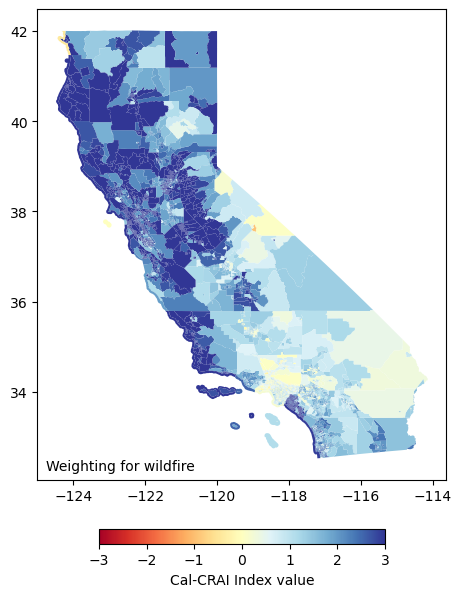

In [22]:
index_plot(df_fire, scenario='wildfire')

In [14]:
# different weighting
df_heat = weight_domains(all_domains, society=1.2, built=1.2, natural=1.3)
df_heat = calculate_index(df_heat)
df_heat.to_csv('calcrai_index_heat_scenario.csv', index=False)

print_index_summary(df_heat)


Min score / less resilience:  -0.402248218606518
Max score / more resilience:  23.919148061093413
Mean score / average resilience:  2.392120123686882
Median score / median resilience:  1.8449443697713641


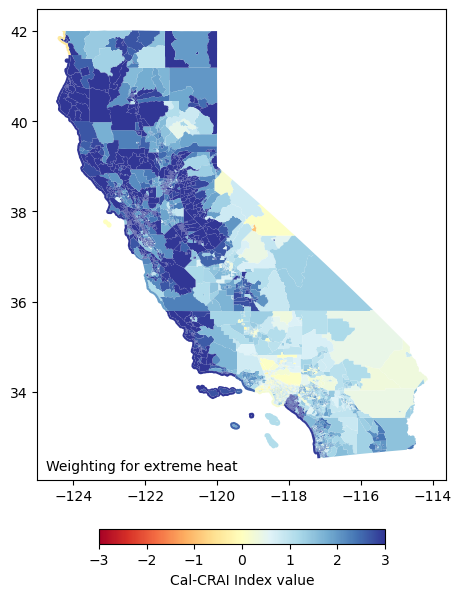

In [25]:
index_plot(df_heat, scenario='extreme heat')

In [16]:
# different weighting
df_inland_flooding = weight_domains(all_domains, society=1.1, built=1.3, natural=1.5)
df_inland_flooding = calculate_index(df_inland_flooding)
df_inland_flooding.to_csv('calcrai_index_inland_flooding_scenario.csv', index=False)

print_index_summary(df_inland_flooding)


Min score / less resilience:  -0.5550078472493151
Max score / more resilience:  24.983504138216137
Mean score / average resilience:  2.381996375316293
Median score / median resilience:  1.8124014397073849


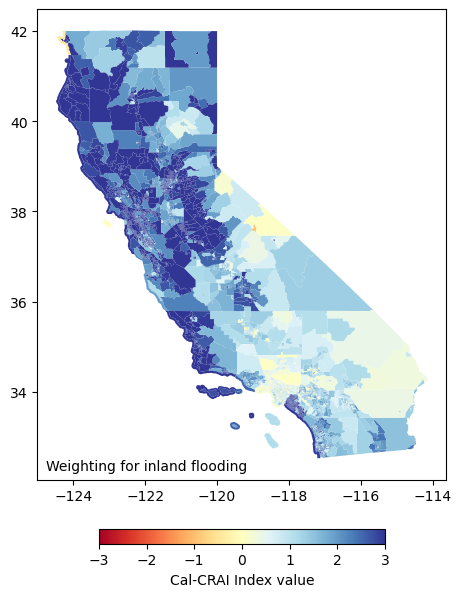

In [26]:
index_plot(df_inland_flooding, scenario='inland flooding')

In [18]:
# different weighting
df_sea_level_rise = weight_domains(all_domains, society=1.1, built=1.3, natural=1.2)
df_sea_level_rise = calculate_index(df_sea_level_rise)
df_sea_level_rise.to_csv('calcrai_index_inland_sea_level_rise_scenario.csv', index=False)

print_index_summary(df_sea_level_rise)


Min score / less resilience:  -0.38938609244995126
Max score / more resilience:  24.011283812854856
Mean score / average resilience:  2.4346292235851097
Median score / median resilience:  1.8744868377280188


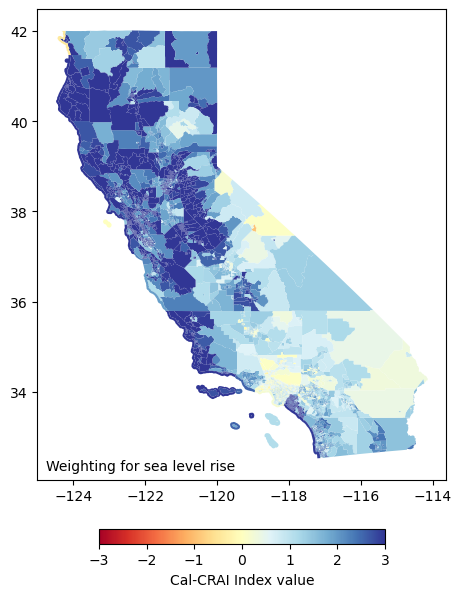

In [27]:
index_plot(df_sea_level_rise, scenario='sea level rise')

In [20]:
# different weighting
df_drought = weight_domains(all_domains, society=1.2, built=1.1, natural=1.5)
df_drought = calculate_index(df_drought)
df_drought.to_csv('calcrai_index_drought_scenario.csv', index=False)

print_index_summary(df_drought)


Min score / less resilience:  -0.9576085283670643
Max score / more resilience:  24.046978872915595
Mean score / average resilience:  2.3400504478668136
Median score / median resilience:  1.802134446217096


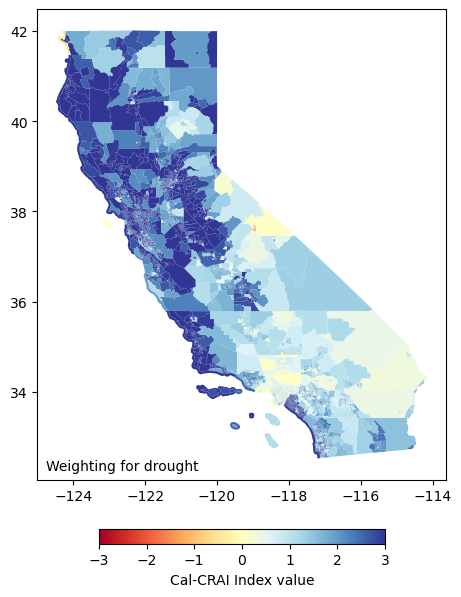

In [28]:
index_plot(df_drought, scenario='drought')

In [ ]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files = ['calcrai_wildfire_scenario_index.csv',
        'calcrai_heat_scenario_index.csv',
        'calcrai_inland_flooding_scenario_index.csv',
        'calcrai_index_inland_sea_level_rise_scenario.csv',
        'calcrai_index_drought_scenario.csv']

for file in files:
    upload_csv_aws([file], bucket_name, directory)

### Step 3: Visualize Results
Let's visualize the results! We'll also demonstrate the power of different customized weighting scenarios. 

In the cells below, we produce a map of the Cal-CRAI across California, as well as comparison maps of the input domains in order to provide context as to the relative importance of each domain in the final calculation. 

#### 3a) Equal Weighting of Domains
This is the "standard" version of the Cal-CRAI calculation -- where the input domains `Society & Economy`, `Built Environment`, and `Natural Systems` are equally weighted in importance. This ensures that we capture a baseline of conditions across California. 

**Note**: These maps are produced with *synthetic* data and do not represent the actual CalCRAI values per census tract. This "real" data is currently being calculated, and these maps will be updated!

In [ ]:
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries.head()

In [25]:
def index_plot(df, scenario=None, save=False):
    '''Maps the Cal-CRAI index value for entire state'''

    # plotting help
    df2 = df.merge(ca_boundaries, on='GEOID')
    df2['geometry'] = df2['geometry']
    df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)

    # set-up figure
    fig, ax = plt.subplots(1, 1, figsize=(4.5,6), layout='compressed')

    df2.plot(column='calcrai_score', ax=ax, vmin=-3, vmax=3, legend=True, cmap='RdYlBu',
                     legend_kwds={'label':'Cal-CRAI Index value', 'orientation': 'horizontal', 'shrink':0.7});

    if scenario == None:
        plt.annotate('Equal-weighted domains'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')
    if scenario != None:
        plt.annotate('Weighting for {}'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')

    if save:
        fig.savefig('equal_weight_calcrai_score.png', dpi=300, bbox_inches='tight') ## need to replace fig name once data repo completed

In [ ]:
index_plot(calcrai_index_equal_weight)

To interpret these maps, a **positive** value indicates a high resilience score, while a **negative** value indicates a low resilience score. 

Now let's look at the input domains as well: 

In [32]:
def _domain_plot_weighting(df, society, built, natural):
    '''In order to visualize the importance of weighting each domain'''
    df['society_economy_tract_adjusted'] = df['society_economy_tract_adjusted'] * society
    df['built_tract_adjusted'] = df['built_tract_adjusted'] * built
    df['natural_tract_adjusted'] = df['natural_systems_tract_adjusted'] * natural
    return df

def index_domain_plot(df, scenario=None, society=1, built=1, natural=1, save=False):
    '''Produces subplots of the Cal-CRAI index value and the corresponding domains'''
    # internally weight domains
    df = _domain_plot_weighting(df, society, built, natural)
    
    # plotting help
    df2 = df.merge(ca_boundaries, on='GEOID')
    df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)

    # set-up figure
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(12,6), layout='compressed')
    vmin=-3
    vmax=3
    dmin=-1
    dmax=1
    cm='RdYlBu'

    df2.plot(ax=ax1, column='calcrai_score', vmin=vmin, vmax=vmax, legend=True, cmap=cm,
             legend_kwds={'label':'Cal-CRAI Index value', 'orientation': 'horizontal', 'shrink':0.7});
    df2.plot(ax=ax2, column='society_economy_tract_adjusted', vmin=dmin, vmax=dmax, legend=True, cmap=cm,
             legend_kwds={'label':'Society & Economy \ndomain weight', 'orientation': 'horizontal', 'shrink':0.7});
    df2.plot(ax=ax3, column='natural_systems_tract_adjusted', vmin=dmin, vmax=dmax, legend=True, cmap=cm,
             legend_kwds={'label':'Natural Systems \ndomain weight', 'orientation': 'horizontal', 'shrink':0.7});
    df2.plot(ax=ax4, column='built_tract_adjusted', vmin=dmin, vmax=dmax, legend=True, cmap=cm,
             legend_kwds={'label':'Built Environment \ndomain weight', 'orientation': 'horizontal', 'shrink':0.7});

    if scenario == None:
        ax1.annotate('Equal-weighted domains'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')
    else: 
        ax1.annotate('Weighting for {}'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')

    if save:
        fig.savefig('ca_domains_map.png', dpi=300, bbox_inches='tight') ## need to replace fig name once data repo completed

In [ ]:
index_domain_plot(calcrai_index_equal_weight)